In [1]:
%load_ext autoreload
%autoreload 2

# LOCAL
# PROJECT_PATH = '/Users/ivan_zorin/Documents/DEV/code/ntl/'
# DATA_PATH = '/Users/ivan_zorin/Documents/DEV/data/sgcc/data.csv'
# LOG_DIR = '/Users/ivan_zorin/Documents/DEV/runs/debug/trainer'

# ZHORES
PROJECT_PATH = '/trinity/home/ivan.zorin/dev/code/ntl/'
DATA_PATH = '/trinity/home/ivan.zorin/dev/data/sgcc/data.csv'
LOG_DIR = '/trinity/home/ivan.zorin/dev/logs/debug/one-batch/'

In [2]:
import numpy as np 
from numpy import ndarray
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, robust_scale
from sktime.transformations.series.impute import Imputer

from functools import partial
from types import SimpleNamespace
import os
from tqdm.auto import tqdm
import warnings

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import sys
sys.path.append(PROJECT_PATH)
from ntl.data import SGCCDataset, data_train_test_split
from ntl.data import FillNA, Scale, Reshape, ToTensor, Cutout, Diff
from ntl.models import AE2dCNN
from ntl.trainer import ArgsTrainer
from ntl.utils import fix_seed, get_date, conv2d_shape, convtraspose2d_shape

In [4]:
fix_seed(42)

transforms = [FillNA('drift'), 
            Cutout(256), 
            Scale('minmax'), 
            Reshape((16, 16)),
            lambda x: x[None],
            ToTensor()
]
normal_data = SGCCDataset(DATA_PATH, label=0, nan_ratio=0.75, transforms=transforms, year=2016)
anomal_data = SGCCDataset(DATA_PATH, label=1, nan_ratio=1.0, transforms=transforms, year=2016)

train, test = data_train_test_split(normal_data, anomal_data)

train_loader = DataLoader(train, batch_size=256, drop_last=False, shuffle=True)
test_loader = DataLoader(test, batch_size=256, shuffle=False)


Random seed set as 42


### one batch over-fit

In [29]:
good_samples = [13514, 31358, 22438, 37273, 27456, 23631,  5807,  6256, 15156,
       11908, 24435,  4284, 30432, 14438, 34922, 14227, 14265, 19188,
       18604, 28565, 32588, 32074, 17105, 25790, 23358, 30944, 22187,
        4025, 28155, 24512, 15907, 14469, 37924, 14410, 37580,  8650,
       26277,  2456, 16590, 27892, 17740, 11788, 23845,  7156,  8151,
       26515, 10987, 12560,  2673,  6823, 28365,  8282,  8056, 34814,
       21691, 36458, 28601, 21013, 35513, 23407, 24660,  2639, 21320,
          76]

# bad_samples = 


In [80]:
from copy import deepcopy

In [115]:
def one_batch_training(one_batch_idxs, i=None, lr=0.001):
    batch_size = 64
    # one_batch_idxs = np.random.randint(0, len(normal_data), batch_size)
    loader = DataLoader(torch.utils.data.Subset(normal_data, one_batch_idxs), batch_size=batch_size)


    model = AE2dCNN(bias=False)
    model_copy = deepcopy(model)
    loss = nn.MSELoss(reduction='none')
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=2, verbose=True)
    logger = SummaryWriter(log_dir=os.path.join(LOG_DIR, get_date())) 

    config = SimpleNamespace(**{
        'debug': True,
        'n_debug_batches': 1,
        'log_step': 5,
        'n_epochs': 100,
        'split_val_losses': True,
        'LOG_DIR': LOG_DIR
    })

    trainer = ArgsTrainer(
        train_loader=loader,
        val_loader=loader,
        model=model,
        loss=loss,
        optim=optim,
        scheduler=scheduler,
        config=config,
        logger=logger
    )

    losses = []
    for epoch in tqdm(range(100)):
        train_loss = trainer.train_step(epoch)
        trainer.logger.add_scalars('loss', {'train': train_loss}, epoch)
        losses.append(train_loss.item())
        
    
    plt.figure()
    plt.plot(losses)
    plt.title(i)
    plt.show()
    print('=' * 60)
    
    return model_copy

In [61]:
batch_size = 64
idxs = np.arange(len(normal_data) - 45).reshape(batch_size, -1).T


In [ ]:
warnings.filterwarnings('ignore')
for i, idx in enumerate(idxs):
    one_batch_training(idx, i)
    

In [78]:
print(idxs[0])

[    0   604  1208  1812  2416  3020  3624  4228  4832  5436  6040  6644
  7248  7852  8456  9060  9664 10268 10872 11476 12080 12684 13288 13892
 14496 15100 15704 16308 16912 17516 18120 18724 19328 19932 20536 21140
 21744 22348 22952 23556 24160 24764 25368 25972 26576 27180 27784 28388
 28992 29596 30200 30804 31408 32012 32616 33220 33824 34428 35032 35636
 36240 36844 37448 38052]


  0%|          | 0/100 [00:00<?, ?it/s]

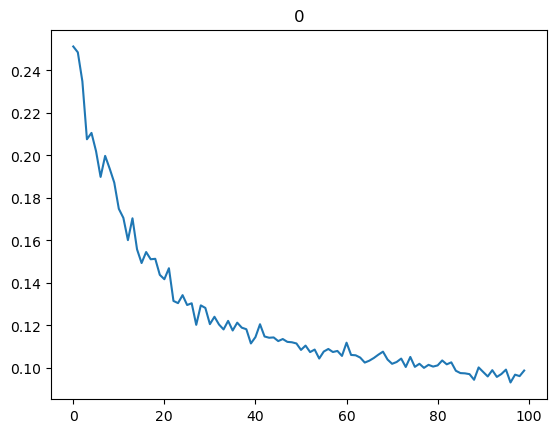

  0%|          | 0/100 [00:00<?, ?it/s]

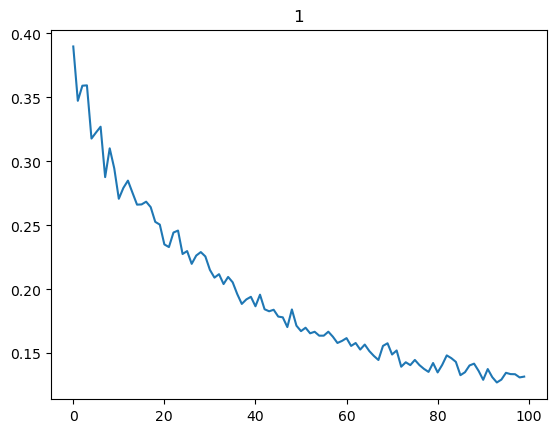

  0%|          | 0/100 [00:00<?, ?it/s]

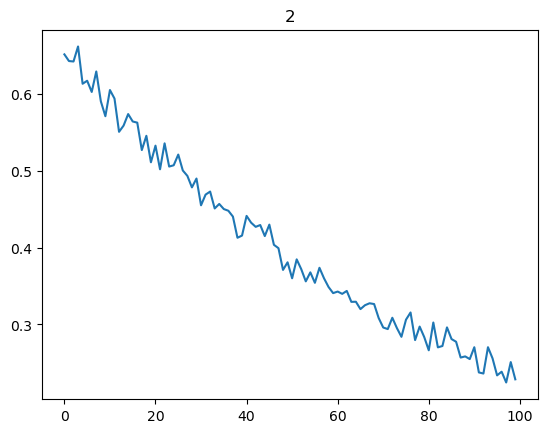

  0%|          | 0/100 [00:00<?, ?it/s]

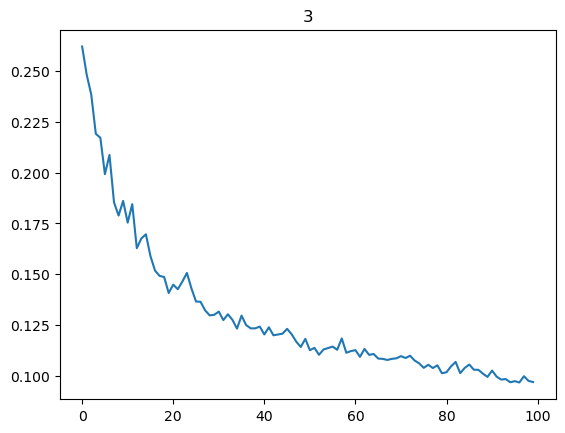

  0%|          | 0/100 [00:00<?, ?it/s]

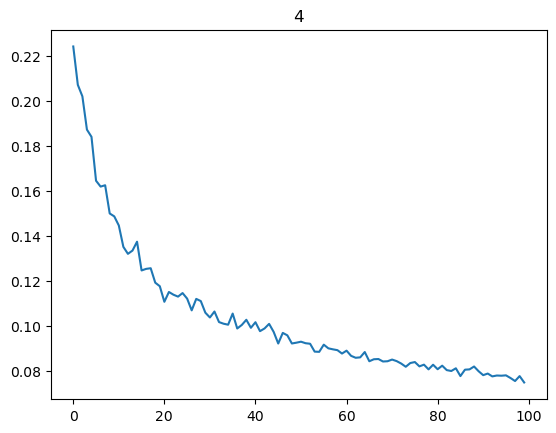

In [117]:
models = []
for i in range(5):
    model = one_batch_training(idxs[0, :], i, lr=0.0001)
    models.append(model)
    print('=' * 10)


In [106]:
channels = [1, 4, 16, 32, 64]
hin = 16
hins = [hin]
for channel in channels:
    hin = conv2d_shape(hin, pad=0, dilation=1, kernel=3, stride=1)
    hins.append(int(hin))

hins = [[h, h] for h in hins]
    

In [ ]:
for sample in train:
    x = sample[1]
    emb, x_hat = trainer.model(x.to(trainer.device))

    x = x.flatten().numpy().squeeze()
    x_hat = x_hat.detach().flatten().cpu().numpy().squeeze()
    plt.figure()
    plt.plot(x, 'b--')
    plt.plot(x_hat, 'r')
    plt.show()

In [ ]:
for i, sample in enumerate(train):
    x = sample[1].flatten().numpy().squeeze()
    plt.figure()
    plt.plot(np.diff(x, n=1))
    plt.title(i)
    plt.show()
    

#### check average values of normalized inputs

In [ ]:
transforms = [FillNA('drift'), 
            Cutout(256), 
            Scale('minmax'), 
            # Reshape((16, 16)),
            # lambda x: x[None],
            # ToTensor()
]
normal_data = SGCCDataset(DATA_PATH, label=0, nan_ratio=0.75, transforms=transforms, year=2016)
anomal_data = SGCCDataset(DATA_PATH, label=1, nan_ratio=1.0, transforms=transforms, year=2016)

train, test = data_train_test_split(normal_data, anomal_data)

In [ ]:
max_values, min_values, mean_values, median_values = [], [], [], []
for sample in tqdm(train):
    x = sample[1]
    max_values.append(x.max())
    min_values.append(x.min())
    mean_values.append(x.mean())
    median_values.append(np.median(x))
    

In [ ]:
def plot_hist(data, title=''):
    plt.figure()
    plt.hist(data, density=True)
    plt.title(title)
    plt.show()
    


In [ ]:
# plot_hist(max_values, 'max_values')
# plot_hist(min_values, 'min_values')
plot_hist(mean_values, 'mean_values')
# plot_hist(median_values, 'median_values')


In [ ]:
idx = 10
sample = train[idx][1]
print(sample.mean())

plt.figure()
plt.plot(sample)
plt.show()


### Transformations 

In [ ]:
transforms = [
    FillNA('drift'), 
    # Cutout(256), 
    # Scale('minmax'), 
    # Reshape((16, 16)),
    # lambda x: x[None],
    # ToTensor()
]
data = SGCCDataset(DATA_PATH, label=0, nan_ratio=0.75, transforms=transforms, year=2016)

In [ ]:
diff_tr = Diff(1)
scale_tr = Scale('minmax')

In [ ]:
idx = np.random.randint(0, len(data))
x = data[idx][1]

In [ ]:
x1 = diff_tr(scale_tr(x))
x2 = scale_tr(diff_tr(x))

In [ ]:
plt.figure()
plt.plot(x1, 'b', label='x1')
plt.plot(x2, 'r', label='x2')
plt.show()


* normalize data to 0,1 scale | check
* fill nans | check
* cut-out some piece | check
* reshape into matrix (7x52, square, other?) | check
* use this matrix as input into AE | check


Two ways of transformation 
The first one 
1. cut-out some piece
2. fill na
3. scale 
4. reshape

The second one 
1. fill na
2. scale
3. cut-out some piece
5. reshape

**#TODO**

* add x and x_hat plots
* split val_loss into two -- val_normal_loss, val_anomal_loss
* add GMM on scores
